# Running experiments
In the following blocks, you can uncomment the code to run the experiments. The code is commented out to avoid running it by accident.

There are 3 types of experiments:
1. Training a new model and testing its performance. The created model and output data will be saved to be reused or analysed below.
2. Training and testing new models using 10-fold cross-validation. The output data will be saved to be reused or analysed below.
3. Loading a pretrained model and testing its performance. The output data will be saved to be reused or analysed below.

In the cell below, you can find the parameters for the experiments. The parameters are the same for all experiments. The only difference is the function that is called.

## Parameters


In [ ]:
# TRAINING PARAMETERS
EARLY_STOPPING = True # use early stopping
PATIENCE = 3 # number of epochs to wait for improvement before early stopping
LEARNING_RATE = 2e-5 # learning rate for the optimizer
BATCH_SIZE = 8 # batch size for training

# ARCHITECTURE & CONTEXT PARAMETERS
MAX_LENGTH = 512 # maximum length of the input sequence, by default, sequences are padded or truncated to this length
SKIP_OVERFLOWING_OBSERVATIONS = True  # skip observations that exceed the max length instead of truncating them
INCLUDE_POS = True  # include POS tags in the input data for more context
INCLUDE_QUERY = True  # include the query in the input for more context

# DATA PARAMETERS
INPUT_DATA_PATH = '../data/preprocessed/val_preprocessed.json'  # location of the preprocessed data to train and test on
OUTPUT_DATA_PATH = '../data/output/val_predictions_mbert_POSSKIP.csv'  # location to save the predictions of the model
MODEL_PATH = "./mbert_token_classifier_POSSKIP/"  # path for saving new model (experiments 1. and 2.) or loading pretrained model (experiment 3.)

DEBUG = False  # print extra information during runtime (not recommended for large datasets)


In [ ]:
# DO NOT CHANGE THE CODE BELOW!!
from NN_utils import NN_Args
args = ()
args.MAX_LENGTH = MAX_LENGTH
args.patience = PATIENCE
args.include_POS = INCLUDE_POS
args.include_query = INCLUDE_QUERY
args.skip_overflowing_observation = SKIP_OVERFLOWING_OBSERVATIONS
args.data_path = INPUT_DATA_PATH
args.output_path = OUTPUT_DATA_PATH
args.model_path = MODEL_PATH
args.DEBUG = DEBUG


## Experiment 1: Train and test a new model
Depending on the size of the dataset, this experiment can take a long time to run. The model will be saved to the path specified in the parameters above. The output data will be saved to the path specified in the parameters above.

In [ ]:
from NN_Classifier import train_and_test_model
# UNCOMMENT THIS LINE TO RUN THE EXPERIMENT
# train_and_test_model(args) # train a new model and test it once

## Experiment 2: Train and test a new model using cross-validation
This experiment will train and test a new model using 10-fold cross-validation. The output data will be saved to the path specified in the parameters above. Without a GPU, this experiment can take a VERY long time to run.

In [ ]:
from NN_Classifier import train_and_test_cross_validation
# UNCOMMENT THIS LINE TO RUN THE EXPERIMENT
# train_and_test_cross_validation(args) # train and test a new model using cross-validation

## Experiment 3: Load a pretrained model and test it
This experiment will load a pretrained model and test it on the evaluation data. The output data will be saved to the path specified in the parameters above. The runtime of this experiment is relatively short, even without a GPU.

In [ ]:
from NN_Classifier import load_and_test_model
# UNCOMMENT THIS LINE TO RUN THE EXPERIMENT
# load_and_test_model(args) # load a pretrained model and test it

# Qualitative analysis

In [18]:
# IMPORTS & PREP STUFF. DONT CHANGE
import pandas as pd
from NN_utils import get_data_for_NN, set_seed

from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

set_seed(420)


# FUNCTIONS FOR EVALUATION
def compute_accuracy(y, yhat):
    correct = sum(1 for yt, yh in zip(y, yhat) if yt == yh)
    return correct / len(y)

def compute_recall(y, yhat):
    true_positives = sum(1 for yt, yh in zip(y, yhat) if yt == 1 and yh == 1)
    false_negatives = sum(1 for yt, yh in zip(y, yhat) if yt == 1 and yh == 0)
    # Avoid division by zero
    if true_positives + false_negatives == 0:
        return 0.0
    return true_positives / (true_positives + false_negatives)

## Label length weirdness
While comparing actual and predicted labels, we came across the weird problem, that the labels did not match the original text inputs anymore. To be exact, the labels were suddenly more numerous than the tokens we had them for. Here is the reason: The tokeniser splits some words that we would otherwise not think to split (of row 426 of the evaluation data, i.e. after overflow handling):


These are the input tokens after tokenisation. The word „Fußball“ has been split into 3 tokens, at positions 19, 20, 21


Curiously, they have different labels, according to our model at least. Originally, of course, theyre identical.
Here is another example for Wals-Siezenheim. Wals was apparently false, while Siezenheim was correct. Both town-names were split.

## Analysing the output of a model
The expected input is a delimiter text file, the delimiter being "[DELIM]", as commas and semicolons are too common to be usable

In [160]:
import re 
def join_numbers_in_string(text):
    # Join the list into a single string
    joined = " ".join(text)
    # Use regex to remove spaces between number, period, and number
    cleaned = re.sub(r'(\d)\s*\.\s*(\d)', r'\1.\2', joined)
    # Split back into a list
    return cleaned.split()



def load(path):
    with open(datapath, "r") as f:
        raw_data = f.readlines()
    # each row is a CSV, but with "DELIM" instead of a comma as delimiter
    df = pd.DataFrame([row.split("[DELIM]") for row in raw_data], columns=["features", "y", "yhat"])
    # preprocess for a clean dataframe
    df.features = df.features.apply(lambda x: [a for a in eval(x) if a not in ["[CLS]", ["PAD]"]]])
    df.y = df.y.str[1:-1].str.split()
    df.yhat = df.yhat.str[1:-2].str.split()
    
    # the features often have words that are separated by the tokenizer
    # the continuations are prepended by "##", so this string is the indicator that the word needs to be joined back together
    # we make it easy: we join back the list, replace " ##" and split it again
    #df.features = df.features.apply(lambda x: " ".join(x).replace(" ##", "").split())
    
    df.y = df.y.apply(lambda l: [int(x) for x in l])
    df.yhat = df.yhat.apply(lambda l: [int(x) for x in l])
    
    # split the features column into query and response
    df["sep_indices"] = df.features.apply(lambda l: [i for i, token in enumerate(l) if token == "[SEP]"])
    df["first_sep_index"] = df.features.apply(lambda l: l.index("[SEP]"))
    
    df["question"] = df.apply(lambda row: row.features[:row.sep_indices[0]], axis=1)
    df["response"] = df.apply(lambda row: row.features[row.sep_indices[0]+1 : row.sep_indices[1]], axis=1)

    # drop the features column
    df = df.drop("features", axis=1)
    # reorder the cols
    #df = df[["question", "response", "y", "yhat"]]
    
    # compute the lengths of the token lists and the outputs:
    #df["len_question"] = df.question.apply(lambda l: len(l))
    df["len_response"] = df.response.apply(lambda l: len(l))
    df["len_y"] = df.y.apply(lambda l: len(l))
    df["len_yhat"] = df.yhat.apply(lambda l: len(l))
    
    # jsome numbers hav been split, e.g. "50.000" is ["50", ".", "000"]
    df.loc[df.len_response != df.len_y, "response"] = df.loc[df.len_response != df.len_y, "response"].apply(join_numbers_in_string)
    # update the list lengths
    df["len_response"] = df.response.apply(lambda l: len(l))
    df["len_y"] = df.y.apply(lambda l: len(l))
    df["len_yhat"] = df.yhat.apply(lambda l: len(l))

    # OPTIONAL
    # the strings "<|im_end|>" are split into 7 pieces, to match the list lengths like the tokenizer saw it, they should be 2 pieces
    df.response = df.response.apply(lambda x: " ".join(x).replace("< | im _ end | >", "<|im end|>").split())
    # update the list lengths
    df["len_response"] = df.response.apply(lambda l: len(l))
    df["len_y"] = df.y.apply(lambda l: len(l))
    df["len_yhat"] = df.yhat.apply(lambda l: len(l))

    
    # evaluation
    df['accuracy'] = df.apply(lambda row: compute_accuracy(row['y'], row['yhat']), axis=1)
    df['recall'] = df.apply(lambda row: compute_recall(row['y'], row['yhat']), axis=1)

    df["hallucinations"]  = df.apply(lambda row: [token for i, token in enumerate(row.response) if row.y[i] == 1], axis=1)
    df["false_negatives"]  = df.apply(lambda row: [token for i, token in enumerate(row.response) if row.y[i] == 1 and row.yhat[i] == 0], axis=1)

    
    # response_clean = response but without POS
    df["response_clean"] = df.apply(lambda row: [row.response[i] for i, label in enumerate(row.y) if int(label) != -100], axis=1)
    df["question_clean"] = df.question.apply(lambda q: " ".join(q).replace(" ##", "").split())
    df["question_clean"] = df.question_clean.apply(lambda q: " ".join([t for i, t in enumerate(q) if i % 3 == 0]))

    
    df["lang"] = df.response.apply(lambda x: detect(clean_tokens(x)))
    df["FN"] = df.false_negatives.apply(len)
    
    
    return df





def show_single_row(i):
    try:
        print(f"Row {i}")
        with pd.option_context('display.max_colwidth', None):
            display(df.iloc[i])
    except: 
        print(f"Row {i} not available!")



def remove_ignored_labels(y, yhat):
    y_2 = [y_i for y_i in y if y != -100]
    yhat_2 = [yhat[i] for i, y_i in enumerate(y) if y_i != -100]
    return y_2, yhat_2

def compute_accuracy(y, yhat):
    y, yhat = remove_ignored_labels(y, yhat)
    correct = sum(1 for yt, yh in zip(y, yhat) if yt == yh)
    return correct / len(y)

def compute_recall(y, yhat):
    y, yhat = remove_ignored_labels(y, yhat)
    true_positives = sum(1 for yt, yh in zip(y, yhat) if yt == 1 and yh == 1)
    false_negatives = sum(1 for yt, yh in zip(y, yhat) if yt == 1 and yh == 0)
    # Avoid division by zero
    if true_positives + false_negatives == 0:
        return 0.0
    return true_positives / (true_positives + false_negatives)



datapath = "../data/output/val_predictions_mbert_POSSKIP.csv"
df = load(datapath)
display(df)
show_single_row(497)

,y,yhat,sep_indices,first_sep_index,question,response,len_response,len_y,len_yhat,accuracy,recall,hallucinations,false_negatives,response_clean,question_clean,lang,FN
0,"[0, 0, 0, 0, -100, -100, -100, -100, -100, -10...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ...","[108, 245]",108,"[¿, P, ##UN, ##CT, fia, el, DE, ##T, da, ##0, ...","[h, ##ü, ##ffel, ##sheim, PR, ##OP, ##N, np, #...",136,136,136,0.014706,0.000000,"[bavi, ##era, ,]",[],"[h, ##ü, ##ffel, ##sheim, ser, uno, municipio,...","¿ el municipio hüffelsheim , estar ubicado en ...",ca,0
1,"[0, -100, -100, -100, -100, -100, -100, 0, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[77, 165]",77,"[¿, P, ##UN, ##CT, fia, en, AD, ##P, sp, ##s, ...","[el, DE, ##T, da, ##0, ##fs, ##0, ciudad, NO, ...",87,87,87,0.034483,0.000000,[],[],"[el, ciudad, de, to, ##ru, ##ń, él, encontrar,...",¿ en qué país él encontrar el ciudad de toruń ?,ca,0
2,"[0, 0, 0, -100, -100, -100, -100, -100, -100, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[76, 162]",76,"[¿, P, ##UN, ##CT, fia, en, AD, ##P, sp, ##s, ...","[le, ##wis, ##town, PR, ##OP, ##N, np, ##000, ...",85,85,85,0.047059,0.000000,"[montana, ,]","[montana, ,]","[le, ##wis, ##town, él, encontrar, en, el, est...",¿ en qué estado de Estados unido él encontrar ...,es,2
3,"[0, 0, -100, -100, -100, -100, -100, 0, 0, -10...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[36, 115]",36,"[when, AD, ##V, WR, ##B, do, AU, ##X, V, ##B, ...","[Je, ##f, PR, ##OP, ##N, NN, ##P, Ra, ##kin, P...",78,78,78,0.051282,0.000000,"[1, ,, 2011, ., year]","[1, ,, 2011, ., year]","[Je, ##f, Ra, ##kin, die, on, March, 1, ,, 201...",when do Jef Raskin die ?,en,5
4,"[0, 0, 0, -100, -100, -100, 1, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[48, 510]",48,"[玳, 瑁, 蜗, 牛, NO, ##UN, NN, 属, PA, ##RT, SF, ##...","[玳, 瑁, 螺, NO, ##UN, NN, （, P, ##UN, ##CT, (, 学...",461,461,461,0.056399,0.466667,"[（, 学, 名, margin, ##ata, ）, ，, 、, 宝, 螺, ，, 是, ...","[（, 学, 名, margin, ##ata, ）, ，, 、, 宝, 螺, ，, 科, ...","[玳, 瑁, 螺, （, 学, 名, ：, Arch, ##acha, ##tina, ma...",玳 牛 属 的 物 NN VERB ADP 些 地 NN .,vi,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,"[0, -100, -100, -100, -100, 0, 0, -100, -100, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[64, 160]",64,"[wie, AD, ##V, KO, ##US, viel, DE, ##T, P, ##I...","[der, DE, ##T, AR, ##T, Gil, ##ette, PR, ##OP,...",95,95,95,0.031579,0.000000,"[Zuschauer, groß, Stadion, in, der, NFL, .]","[der, NFL, .]","[der, Gil, ##ette, Stadium, sein, mit, ein, Ka...",wie viel Zuschauer haben Platz in der Gillette...,de,3
495,"[0, -100, -100, -100, -100, -100, -100, -100, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[127, 326]",127,"[hur, AD, ##V, H, ##A, många, AD, ##J, JJ, |, ...","[den, PR, ##ON, P, ##N, |, NE, ##U, |, SI, ##N...",198,198,198,0.010101,0.000000,"[antal, sida]",[antal],"[den, finn, ##as, ingen, känd, upp, ##ska, ##t...",hur många | UTR | IND | NOUN NEU | NOM VB | PR...,sv,1
496,"[0, 0, -100, -100, -100, 0, 0, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[51, 510]",51,"[金, 属, NO, ##UN, NN, 键, PA, ##RT, SF, ##N, 决, ...","[金, 属, NO, ##UN, NN, 晶, 体, NO, ##UN, NN, 中, AD...",458,458,458,0.069869,0.000000,[],[],"[金, 属, 晶, 体, 中, ，, 金, 属, 原, 子, 之, 间, 通, 过, 金, ...",金 NN SFN VERB AUX 属 的 哪 DT NOUN 质 ？,vi,0
497,"[0, -100, -100, -100, -100, 0, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[130, 263]",130,"[gegen, AD, ##P, AP, ##PR, welcher, DE, ##T, P...","[Hamilton, PR, ##OP, ##N, NE, Academic, PR, ##...",132,132,132,0.060606,0.000000,"[Liga, gegen, Rovers, und, in, der, zwei, ##t,...","[Liga, gegen, Rovers, und, in, der, zwei, ##t,...","[Hamilton, Academic, ver, ##liere, ##n, [PAD],...",gegen welcher Verein verlieren Hamilton Academ...,de,11


Row 497


y                  [0, -100, -100, -100, -100, 0, -100, -100, -100, -100, 0, 0, 0, -100, -100, -100, -100, -100, -100, 0, -100, -100, 0, -100, -100, -100, -100, 0, -100, -100, -100, -100, 0, 0, -100, -100, -100, 0, -100, -100, -100, -100, -100, 0, -100, -100, -100, 0, -100, -100, -100, -100, 0, 0, -100, -100, -100, -100, -100, 1, -100, -100, -100, 1, -100, -100, -100, -100, 0, -100, -100, -100, -100, 0, -100, -100, -100, -100, 1, -100, -100, -100, -100, 1, -100, -100, -100, -100, -100, 0, 0, 0, -100, -100, -100, -100, -100, -100, 1, -100, ...]
yhat                                                                                                                                                                                                                                                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [78]:
def clean_tokens(l:list, aslist=False):
    out= " ".join(l).replace(" ##", "")
    if aslist: out = out.split()
    return out

total = 0
for i, row in df.iterrows():  # Use _ to ignore the index
    if len(row["false_negatives"]) !=0:
        print("      False negatives:\t", clean_tokens(row["false_negatives"]))
        print("Actual hallucinations:\t", clean_tokens(row["hallucinations"]))
        print("Recall:", row["recall"])
        
        print("\tFrom response:", clean_tokens(row["response_clean"]))
        print("\tQuery:", clean_tokens(row["question"]))
        total+=1
        print()
print(total)

      False negatives:	 montana ,
Actual hallucinations:	 montana ,
Recall: 0.0
	From response: lewistown él encontrar en el estado de montana , Estados unido .
	Query: ¿ PUNCT fia en ADP sps00 qué DET dt0cn0 estado NOUN ncms000 de ADP sps00 Estados PROPN np00000 unido PROPN [PAD] él PRON p0000000 encontrar VERB vmip3s0 lewistown PROPN np00000 ? PUNCT fit

      False negatives:	 1 , 2011 . year
Actual hallucinations:	 1 , 2011 . year
Recall: 0.0
	From response: Jef Rakin die on March 1 , 2011 . he be 88 year old .
	Query: when ADV WRB do AUX VBD Jef PROPN NNP Raskin PROPN NNP die VERB VB ? PUNCT .

      False negatives:	 （ 学 名 marginata ） ， 、 宝 螺 ， 科 热 带 地 区 ， 包 括 、 斯 加 分 在 中 找 到 ， 如 、 草 原 、 泽 。 具 有 很 高 的 商 业 价 ， 因 捕 捉
Actual hallucinations:	 （ 学 名 marginata ） ， 、 宝 螺 ， 是 科 的 一 的 热 带 地 区 ， 包 括 、 南 非 、 马 达 加 斯 加 以 及 部 分 西 非 国 家 。 在 生 境 中 找 到 ， 如 、 草 原 、 沼 泽 和 农 田 等 。 具 有 很 高 的 商 业 价 值 ， 因 过 度 捕 捉 ，
Recall: 0.4666666666666667
	From response: 玳 瑁 螺 （ 学 名 ： Archachatina marginata ） ， 又 称

In [80]:
# print all rows with year numbers
def clean_tokens(l:list, aslist=False):
    out= " ".join(l).replace(" ##", "")
    if aslist: out = out.split()
    return out
total = 0

for _, row in df.iterrows():  # Use _ to ignore the index
    if bool(re.search(r" \d\d\d\d ", clean_tokens(row["false_negatives"]))):
        print("      False negatives:\t", clean_tokens(row["false_negatives"]))
        print("Actual hallucinations:\t", clean_tokens(row["hallucinations"]))
        print("Recall:", row["recall"])
        
        print("\tFrom response:", clean_tokens(row["response_clean"]))
        print("\tQuery:", clean_tokens(row["question"]))
        print()
        total+=1
total

      False negatives:	 1 , 2011 . year
Actual hallucinations:	 1 , 2011 . year
Recall: 0.0
	From response: Jef Rakin die on March 1 , 2011 . he be 88 year old .
	Query: when ADV WRB do AUX VBD Jef PROPN NNP Raskin PROPN NNP die VERB VB ? PUNCT .

      False negatives:	 Gustav ii adolf , también conocido como Gustav ii Adolfo el victorioso . 1611 hasta 1632 .
Actual hallucinations:	 Gustav ii adolf , también conocido como Gustav ii Adolfo el victorioso . 1611 hasta 1632 .
Recall: 0.0
	From response: el rey sueco que iniciar el Armada de suecia ser Gustav ii adolf , también conocido como Gustav ii Adolfo el victorioso . ser el rey de suecia desde 1611 hasta 1632 .
	Query: ¿ PUNCT fia qué DET dt0cn0 rey NOUN ncms000 sueco ADJ aq0ms0 iniciar VERB vmis3s0 el DET da0fs0 armada NOUN ncfs000 de ADP sps00 suecia PROPN np00000 ? PUNCT fit

      False negatives:	 चार्ल्स रोल्फ मैंगेर्स । 1985 से 1994
Actual hallucinations:	 चार्ल्स रोल्फ मैंगेर्स । 1985 से 1994
Recall: 0.0
	From response: दक्ष

41

In [72]:
# there are 447 rows with false negatives!
# 41 of them include years

388

In [161]:
# what about < | im _ end | >
total=0
df["response_string"] = df.response_clean.apply(lambda x: " ".join(x).replace(" ##", ""))
for _, row in df[df.response_string.str.contains("< | im _ end | >")].iterrows():  
    print("      False negatives:\t", clean_tokens(row["false_negatives"]))
    print("Actual hallucinations:\t", clean_tokens(row["hallucinations"]))
    print("Recall:", row["recall"])
    
    print("\tFrom response:", clean_tokens(row["response_clean"]))
    print("\tQuery:", row["question_clean"])
    print()
    print()
    total+=1
total

      False negatives:	 997 mehrmals
Actual hallucinations:	 997 mehrmals [PAD] 2 . Weltkrieg fast vollständig zerstören . 3 km nach Nordosten
Recall: 1.0
	From response: der polnisich Stadt Thorn ( Toruň ) werden [PAD] in der Jahr 997 gründen und [PAD] in der Lauf der Jahrhundert mehrmals verlagern . [PAD] in der 2 . Weltkrieg werden sie fast vollständig zerstören . der heutig Stadt werden 3 km nach Nordosten versetzen . Quelle : < | im _ end | "
	Query: warum werden der polnisch Stadt Toruń in der 13 . . ADJD ART PIAT NN APPR NN VVPP $


      False negatives:	 " 1 . 005
Actual hallucinations:	 " 1 . 005
Recall: 0.0
	From response: der italienisch Gemeinde " Ponzano " liegen auf ein Höhenlage von etwa 1 . 005 Meter . Quelle : < | im _ end | "
	Query: auf welcher Höhe liegen der italienisch Gemeinde Ponzone ? .


      False negatives:	 Lylo Doublage .
Actual hallucinations:	 Lylo Doublage .
Recall: 0.0
	From response: le série White Collar avoir être doubler en français par le sociét

18

In [134]:
# vi: Vietnamese	
# hi: Hindi
langsum = df.copy()
df["rowcount"] = 1
langsum = df.groupby("lang").sum("FN").sort_values("FN", ascending=False).reset_index()
langsum["rFN"] = langsum.apply(lambda row: round(row.FN / row.rowcount, 1), axis=1)
langsum.sort_values("rFN", ascending=False)[["lang", "FN", "rowcount", "rFN"]].rename({"FN":"False Negatives", "rowcount": "Number of rows", "rFN":"False negatives per row", "lang": "Language"}, axis=1)



,Language,False Negatives,Number of rows,False negatives per row
1,fi,1294,44,29.4
0,vi,1368,50,27.4
2,fr,1177,49,24.0
3,it,706,40,17.6
5,hi,652,48,13.6
11,so,38,3,12.7
6,ar,518,42,12.3
10,pt,61,5,12.2
4,de,656,55,11.9
7,sv,474,42,11.3


<Axes: >

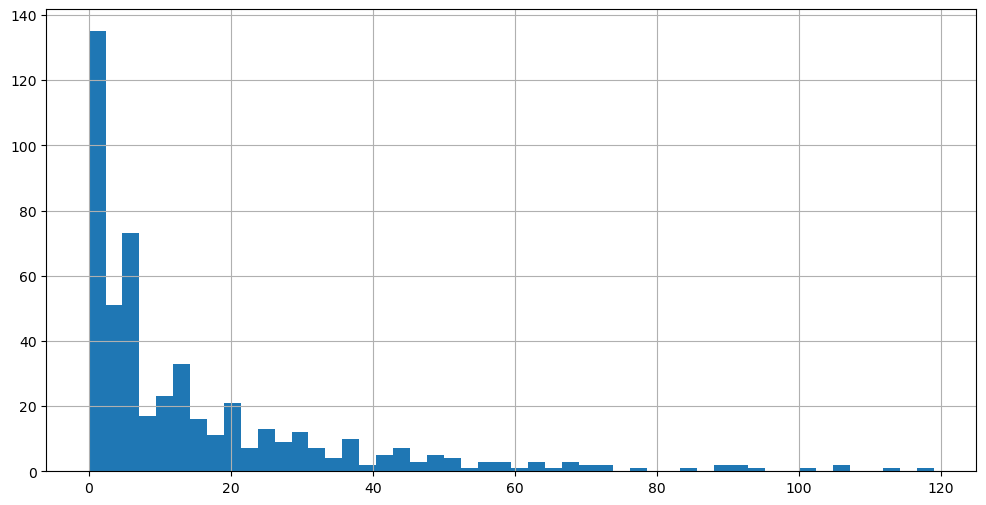

In [120]:
df.FN.hist(bins=50, figsize=(12, 6))

<Axes: >

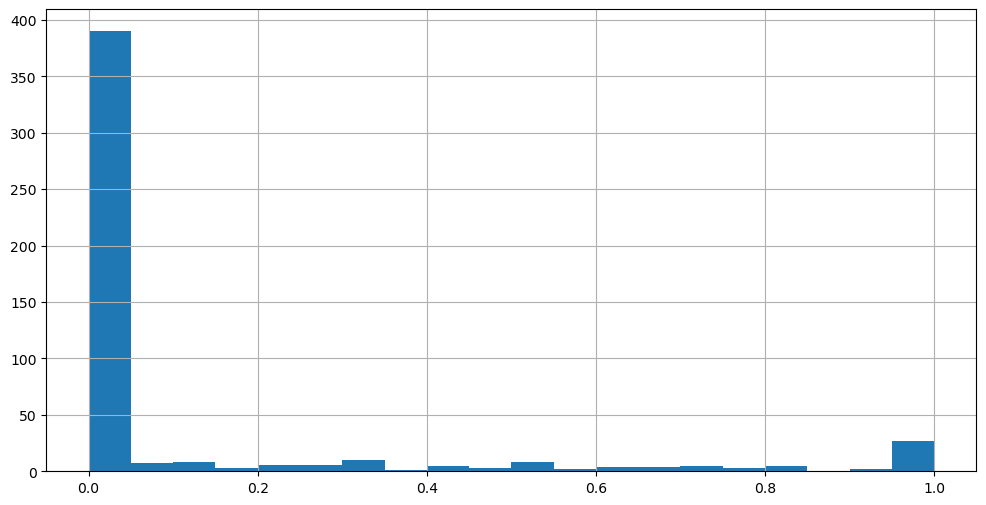

In [124]:
df.recall.hist(bins=20, figsize=(12, 6))

In [129]:
df.recall.mean()

0.12304786825491593

In [169]:
#bool(re.search(r'[^\w\s]', s))
#bool(re.search(r'[^\w\s]', s)) and not bool(re.fullmatch(r'[^\w\s]+', s))

df["FN_punct"] = df.false_negatives.apply(lambda l: sum([bool(re.search(r'[^\w\s]', s)) and not bool(re.fullmatch(r'[^\w\s]+', s)) for s in l]))

In [168]:
df.FN.sum()

7762

In [178]:
oida = df.groupby("lang").agg(row_count=('lang', 'size'), value_sum=('FN_punct', 'sum')).reset_index()
oida["sum_rel"] = oida.value_sum / oida.row_count
oida.sort_values("sum_rel", ascending=False)

,lang,row_count,value_sum,sum_rel
7,fi,44,493,11.204545
9,hi,48,415,8.645833
0,ar,42,262,6.238095
8,fr,49,282,5.755102
15,so,3,17,5.666667
10,it,40,167,4.175000
16,sv,42,147,3.500000
2,de,55,180,3.272727
14,pt,5,14,2.800000
11,ne,2,5,2.500000
